# Dog Breed Classication using AWS Sagemaker
This project uses AWS sage maker to make a classification for 133 classes of dog breeds using a pre-trained model (Resnet 50). <br>
I go over 3 primary step <br>
* Data Preparation step
    * Prepare dog image 
    * upload to S3 
* Training step
    * Hyperparameter Tuning 
    * Train a best performance model and test it 
    * Debugger and Profile Report 
* Deploying step 
    * deploy the model and test it 

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from  sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule, 
    ProfilerRule, 
    rule_configs,
    DebuggerHookConfig, 
    ProfilerConfig, 
    FrameworkProfile,
    CollectionConfig
)


## Dataset
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [5]:
import os
all_classes = [name.split('.') for name in os.listdir("dogImages/train")]
all_classes = dict(all_classes)
all_classes

{'114': 'Otterhound',
 '110': 'Norwegian_lundehund',
 '127': 'Silky_terrier',
 '091': 'Japanese_chin',
 '095': 'Kuvasz',
 '061': 'English_cocker_spaniel',
 '043': 'Canaan_dog',
 '131': 'Wirehaired_pointing_griffon',
 '124': 'Poodle',
 '087': 'Irish_terrier',
 '053': 'Cocker_spaniel',
 '064': 'English_toy_spaniel',
 '105': 'Neapolitan_mastiff',
 '032': 'Boston_terrier',
 '017': 'Bearded_collie',
 '094': 'Komondor',
 '003': 'Airedale_terrier',
 '084': 'Icelandic_sheepdog',
 '122': 'Pointer',
 '098': 'Leonberger',
 '125': 'Portuguese_water_dog',
 '009': 'American_water_spaniel',
 '058': 'Dandie_dinmont_terrier',
 '115': 'Papillon',
 '006': 'American_eskimo_dog',
 '041': 'Bullmastiff',
 '085': 'Irish_red_and_white_setter',
 '081': 'Greyhound',
 '004': 'Akita',
 '103': 'Mastiff',
 '044': 'Cane_corso',
 '118': 'Pembroke_welsh_corgi',
 '013': 'Australian_terrier',
 '117': 'Pekingese',
 '002': 'Afghan_hound',
 '025': 'Black_and_tan_coonhound',
 '129': 'Tibetan_mastiff',
 '093': 'Kerry_blue_ter

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [6]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "project/dog-image"
role = sagemaker.get_execution_role()

In [6]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_range = {
        "lr" : ContinuousParameter(0.001,0.1),
        "batch-size" : CategoricalParameter([32,64,128,256,512]),
        "epochs" : IntegerParameter(6,8)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definition = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_range,
    metric_definition,
    max_jobs=8,
    max_parallel_jobs=2,
    objective_type = objective_type
)

In [8]:
"s3://{}/{}".format(bucket, prefix) + "/train"

's3://sagemaker-us-east-1-817558416634/project/dog-image/train'

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({
        "train" : "s3://{}/{}".format(bucket, prefix) + "/train" , 
        "test" : "s3://{}/{}".format(bucket, prefix) + "/test",
        "val" : "s3://{}/{}".format(bucket, prefix) + "/valid"}) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

In [16]:
# Because the session ended and took a long time to tune, I got the job name from the console 
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName="pytorch-training-220929-1847"
)["BestTrainingJob"]

{'TrainingJobName': 'pytorch-training-220929-1847-008-6338a2f5',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:817558416634:training-job/pytorch-training-220929-1847-008-6338a2f5',
 'CreationTime': datetime.datetime(2022, 9, 29, 19, 40, 4, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 9, 29, 19, 40, 11, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 9, 29, 19, 54, 11, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'batch-size': '"128"',
  'epochs': '6',
  'lr': '0.0010000000000000002'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test loss',
  'Value': 0.616599977016449},
 'ObjectiveStatus': 'Succeeded'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [7]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {"epochs": 6, "batch-size": 128, "lr": 0.0010000000000000002}
#https://knowledge.udacity.com/questions/749611

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing(), rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "100","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debug_config = DebuggerHookConfig(collection_configs=collection_configs)

In [ ]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImages-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config
)
estimator.fit({
        "train" : "s3://{}/{}".format(bucket, prefix) + "/train" , 
        "test" : "s3://{}/{}".format(bucket, prefix) + "/test",
        "val" : "s3://{}/{}".format(bucket, prefix) + "/valid"}, wait = True)

2022-10-02 18:14:32 Starting - Starting the training job...
2022-10-02 18:14:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2022-10-02 18:15:56 Downloading - Downloading input data............
2022-10-02 18:18:04 Training - Downloading the training image..............
2022-10-02 18:20:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-02 18:20:18,071 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-02 18:20:18,102 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-02 18:20:18,110 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-02 18:20:18,671 sagemaker-training-toolkit INFO     Invoking user script
Train

In [32]:
# TODO: Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365
Region: us-east-1
[2022-10-02 18:37:50.491 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:83 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/debug-output
[2022-10-02 18:37:51.089 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:83 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-02 18:37:52.108 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:83 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.bn3.bias', 'gradient/R

In [33]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


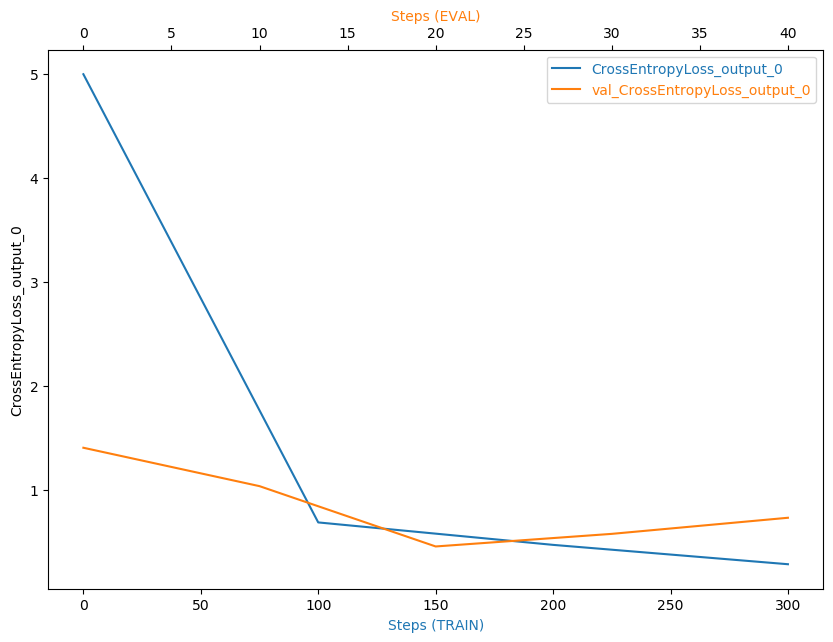

In [35]:
plot_tensor(trial, "CrossEntropyLoss_output_0")


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [36]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [37]:
! aws s3 ls {rule_output_path} --recursive

2022-10-02 18:37:32     415949 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-02 18:37:32     270601 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-02 18:37:27        192 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-02 18:37:27      47641 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-02 18:37:27       1979 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-02 18:37:27        331 smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-02 18:37:27       3971 smdebugger-dogImages-py

In [38]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-8175584

In [39]:
import os
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [40]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [41]:
predictor=estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [42]:
with open ("dogImages/train/100.Lowchen/Lowchen_06671.jpg" , 'rb') as f :
    image = f.read()

In [43]:
import smdebug
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [44]:
response = predictor.predict(image)
response

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/smdebugger-dogImages-pytorch-2022-10-02-18-38-18-856 in account 817558416634 for more information.

In [55]:
model_location = estimator.model_data
#model_location = 's3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/output/model.tar.gz'
model_location

's3://sagemaker-us-east-1-817558416634/smdebugger-dogImages-pytorch-2022-10-02-18-14-32-365/output/model.tar.gz'

In [56]:
import smdebug
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [57]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [61]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py', py_version='py36',
                             framework_version='1.6',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

<img src="7-American_foxhound_00512.jpg" width="500" height="600">

In [62]:
# TODO: Run an prediction on the endpoint
with open ("7-American_foxhound_00512.jpg" , 'rb') as f :
    image = f.read()

In [63]:
response=predictor.predict(image, initial_args={"ContentType": "image/jpeg"})
response

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-10-02-19-20-28-566 in account 817558416634 for more information.

In [39]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()